$改 a(u,\nu) 中 \epsilon (\nu) 为 grad \nu$

## 模型与剖分

In [86]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from fealpy.decorator import cartesian
from fealpy.mesh import TriangleMesh
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.boundarycondition import DirichletBC

class pde():
    def __init__(self, mu=1, lam=1):
        self.mu  = mu
        self.lam = lam
        
    def domain(self):
        return [0, 1, 0, 1]
    
    def init_mesh(self, n=1, meshtype='tri'):
        node = np.array([
            (0,0),
            (1,0),
            (1,1),
            (0,1)], dtype=np.float64)
        cell = np.array([(1,2,0), (3,0,2)], dtype=np.int64)
        mesh = TriangleMesh(node, cell)
        mesh.uniform_refine(n)
        return mesh
    
    @cartesian
    def source(self, p):
        x   = p[..., 0]
        y   = p[..., 1]
        mu  = self.mu
        lam = self.lam
        
        sin = np.sin
        cos = np.cos
        val = np.zeros(p.shape, dtype=np.float64)
        
        val[..., 0] = -((2 * mu + lam) * y * (y - 1) * (2 * cos(x) - (x - 1) * sin(x))
                        + (mu + lam) * (2 * x - 1) * (sin(y) + (y - 1) * cos(y)) 
                        + 2 * mu * (x -1) * sin(x))
        val[..., 1] = -((2 * mu + lam) * x * (x - 1) * (2 * cos(y) - (y - 1) * sin(y))
                        + (mu + lam) * (2 * y - 1) * (sin(x) + (x - 1) * cos(x))
                        + 2 * mu * (y - 1) * sin(y))

        #val[..., 0] = -(2 * (2 * mu + lam) * y * (y - 1) 
        #                + (mu + lam) * (2 * x - 1) * (2 * y - 1)
        #                + 2 * mu * x * (x - 1))
        #val[..., 1] = -(2 * (2 * mu + lam) * x * (x - 1)
        #                + (mu + lam) * (2 * x - 1) * (2 * y - 1)
        #                + 2 * mu * y * (y - 1))
        return val
    
    def dirichlet(self, p):
        var = np.zeros_like(p)
        return var
    
    def solution(self, p):
        x = p[..., 0]
        y = p[..., 1]
        
        val = np.zeros(p.shape, dtype=np.float64)
        
        val[..., 0] = y * (x - 1) * (y - 1) * np.sin(x)
        val[..., 1] = x * (x - 1) * (y - 1) * np.sin(y)
        
        #val[..., 0] = x * (x - 1) * y * (y - 1)
        #val[..., 1] = x * (x - 1) * y * (y - 1)
        return val
        
    def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        flag = np.max(np.abs(y)) < 1e-13 
        return flag
    
def error(u, uh):
    e = u - uh
    emax = np.max(np.abs(e))
    return emax

n = 0
pde = pde()
mesh = pde.init_mesh(n)
NN = mesh.number_of_nodes()
NC = mesh.number_of_cells()
#[NC,2] 剖分点及其编号(下标)
node = mesh.entity('node') 
#[NC,3] 剖分区间及其端点编号
cell = mesh.entity('cell') 
#[NC] 每个单元的面积
cm = mesh.entity_measure()

## 剖分图

In [87]:
#fig = plt.figure()
#ax = fig.gca()
#mesh.add_plot(ax)
#mesh.find_node(ax,showindex=True)
#mesh.find_cell(ax,showindex=True)

## 刚度矩阵

每个单元六个基函数，为$\varphi_1(第一个节点x方向), \varphi_2(第一个节点y方向), \varphi_3(第二个节点x方向), \varphi_4(第二个节点y方向), \varphi_5(第三个节点x方向), \varphi_6(第三个节点y方向)$ 

In [88]:
##[NC,3,2] 每个单元上基函数(三个)对x、y的偏导数
glam_x_y = mesh.grad_lambda()
#print("glam_x_y= ", glam_x_y)
glam_dim4 = np.broadcast_to(glam_x_y[:, :, None, :], shape=(NC,3,2,2)).copy()
#print("glam_dim4= ", glam_dim4)
glam_dim5 = np.broadcast_to(glam_dim4[:, :, :, None, :], shape=(NC,3,2,2,2)).copy()
#print("glam_dim5= ", glam_dim5)
glam_dim5[:, :, 0, 1, :] = 0 # [NC,3(三个节点),2(每个点两个基函数),2,2(后两个指标指基函数的 grad)]
glam_dim5[:, :, 1, 0, :] = 0 # x方向上的基函数第二个分量为0，y方向上的基函数第一个分量为0
#print("glam_dim5= ", glam_dim5)

# [NC,3,2]
glam_div = np.einsum("cnmij->cnm", glam_dim5)
# [NC,6(每个基函数的 div)]
glam_div = glam_div.reshape(NC,6)
#print("glam_sum= ", glam_sum)

glam_v = glam_dim5.reshape(NC,6,2,2)
#print("glam_v= ", glam_v)
glam_t = glam_dim5.swapaxes(3,4)
glam_dim5 = glam_dim5 + glam_t
#print("glam_dim5= ", glam_dim5)
glam_dim4 = glam_dim5.reshape(NC,6,2,2)  #后两个指标指每个基函数的 grad + grad^t
#print("glam_dim4= ", glam_dim4)

# [NC,6,6]
S = np.einsum("cnij, cmij, c->cnm", glam_dim4, glam_v, cm)
#[NC,6,6] 单元刚度矩阵第二部分
M = np.einsum("cn, cm, c->cnm", glam_div, glam_div, cm)


cell_x_y = np.broadcast_to(cell[:,:,None], shape=(NC, 3, 2)).copy()
cell_x_y[:,:,0] = 2 * cell_x_y[:,:,0]       #[NC,3] 三个节点x方向上基函数在总刚度矩阵的位置
cell_x_y[:,:,1] = 2 * cell_x_y[:,:,1] + 1   #[NC,3] 三个节点y方向上基函数在总刚度矩阵的位置
cell_x_y = cell_x_y.reshape(NC, 6)
I = np.broadcast_to(cell_x_y[:, :, None], shape=S.shape)
J = np.broadcast_to(cell_x_y[:, None, :], shape=S.shape)

S = csr_matrix((S.flat, (I.flat, J.flat)), shape=(2 * NN,2 * NN))
M = csr_matrix((M.flat, (I.flat, J.flat)), shape=(2 * NN,2 * NN))
A = pde.mu * S + pde.lam * M
#print("A= ", A.toarray())

In [89]:
def is_Bd_Node_flag():
    n = mesh.number_of_nodes()
    isBdNode = np.zeros(n, dtype=bool)
    for i in range(n):
        if (pde.is_dirichlet_boundary(mesh.node[i])):
            isBdNode[i] = True
    return isBdNode

## 载荷向量与求解

node[cell] [NC,3(三个节点),2(每个节点的 x, y 坐标)] 每个区间上节点的编号为 i,j,k

bb 编号与 $\varphi$ 相同

In [100]:
from fealpy.quadrature import TriangleQuadrature

NQ = 3
Q = int(NQ * (NQ + 1) / 2) # 内积分点数
qf = TriangleQuadrature(NQ)

#bcs [Q,3]; WS[Q,]
bcs,ws = qf.get_quadrature_points_and_weights()
#print("bcs= ", bcs)
#phi [Q,3,2]
phi = np.broadcast_to(bcs[:, :, None], shape=[Q,3,2])
#print("phi= ", phi)

#[Q,3,2(每个内积分节点两个基函数),2(每个基函数两个分量)]
phi_x_y = np.zeros((Q, 3, 2, 2), dtype=np.float64) 
phi_x_y[:, :, :, 0] = phi
phi_x_y[:, :, :, 1] = phi
phi_x_y[:, :, 0, 1] = 0
phi_x_y[:, :, 1, 0] = 0
phi_x_y = phi_x_y.reshape(Q,6,2)
#print("phi_x_y= ", phi_x_y)

# node[cell] [NC,3(三个节点),2(每个节点的 x, y 坐标)]
# ps [Q,NC,2]
# 内积分点标准单元坐标转换为真实坐标
ps = np.einsum('qi, cim->qcm', bcs, node[cell]) 
#print("ps= ", ps)
# val [Q,NC,2] 每个内积分的右端项的值
val = pde.source(ps)
#print("val= ", val)
#bb [NC,6]
bb = np.einsum('q, qcj, qij, c->ci', ws, val, phi_x_y, cm)
#print("cell= ", cell)
#print("bb= ", bb)
#print("cel_x_y= ", cell_x_y)

F = np.zeros(2 * NN)
np.add.at(F, cell_x_y, bb)
#print("F= ", F)

isBdNode = mesh.ds.boundary_node_flag()
isInterNode = ~isBdNode
#print("isInterNode= ", isInterNode)
isInterNode = np.broadcast_to(isInterNode[:, None], shape=(NN, 2))
isInterNode = isInterNode.reshape(2 * NN)
#print("isInterNode= ", isInterNode)

uh = np.zeros((2 * NN), dtype=np.float64)
uh[isInterNode] = spsolve(A[:, isInterNode][isInterNode], F[isInterNode])
#print("uh= ", uh)
uh = uh.reshape(NN, 2)
#print("uh= ", uh)
#print("F[isInterNode]= ", F[isInterNode])

cell=  [[1 2 0]
 [3 0 2]]
bb=  [[0.22442569 0.26676174 0.16969735 0.18252266 0.16907659 0.22534652]
 [0.26676174 0.22442569 0.22534652 0.16907659 0.18252266 0.16969735]]
cel_x_y=  [[2 3 4 5 0 1]
 [6 7 0 1 4 5]]


In [91]:
#def source(p):
#    val = np.ones_like(p)
#    return val
#
#val_exam = source(ps)
#print("val_exam= ", val_exam)
#quad = np.einsum('q, qj, c->cj', ws, phi_x_y[:,0,:], cm)
#print("quad= ", quad)

## 绝对误差

假设按 n=1,2, ... , 6 的顺序执行

In [92]:
if (n == 1):
    h1 = cm[0]
    uh1 = uh
    u1 = pde.solution(node)
elif (n == 2):
    h2 = cm[0]
    uh2 = uh
    u2 = pde.solution(node)
elif (n == 3):
    h3 = cm[0]
    uh3 = uh
    u3 = pde.solution(node)
elif (n == 4):
    h4 = cm[0]
    uh4 = uh
    u4 = pde.solution(node)
elif (n == 5):
    h5 = cm[0]
    uh5 = uh
    u5 = pde.solution(node)
elif (n == 6):
    h6 = cm[0]
    uh6 = uh
    u6 = pde.solution(node)

In [93]:
if (n >= 1):
    e1 = error(u1, uh1)
    print("h= ", h1)
    print("e= ", e1)
    print()
if (n >= 2):
    e2 = error(u2, uh2)
    print("h= ", h2)
    print("e= ", e2)
    print()
if (n >= 3):
    e3 = error(u3, uh3)
    print("h= ", h3)
    print("e= ", e3)
    print()
if (n >= 4):
    e4 = error(u4, uh4)
    print("h= ", h4)
    print("e= ", e4)
    print()
if (n >= 5):
    e5= error(u5, uh5)
    print("h= ", h5)
    print("e= ", e5)
    print()
if (n >= 6):
    e6= error(u6, uh6)
    print("h= ", h6)
    print("e= ", e6)

## 相对误差

In [94]:
def error_rel(uh1, uh2):
    val = uh2[0:uh1.shape[0]] - uh1
    return np.max(np.abs(val))

In [95]:
if (n == 1):
    uh1 = uh
elif (n == 2):
    uh2 = uh
elif (n == 3):
    uh3 = uh
elif (n == 4):
    uh4 = uh
elif (n == 5):
    uh5 = uh
elif (n == 6):
    uh6 = uh

In [96]:
#if (n >= 2):
#    e2 = error_rel(uh1, uh2)
#if (n >= 3):
#    e3 = error_rel(uh2, uh3)
#if (n >= 4):
#    e4 = error_rel(uh3, uh4)
#if (n >= 5):
#    e5 = error_rel(uh6, uh5)
#if (n >= 6):
#    e6 = error_rel(uh5, uh6)

In [97]:
h = np.zeros(6)
e = np.zeros(5)

if (n >= 1):
    h[0] = h1
if (n >= 2):
    h[1] = h2
    e[0] = error_rel(uh1, uh2)
if (n >= 3):
    h[2] = h3
    e[1] = error_rel(uh2, uh3)
if (n >= 4):
    h[3] = h4
    e[2] = error_rel(uh3, uh4)
if (n >= 5):
    h[4] = h5
    e[3] = error_rel(uh4, uh5)
if (n >= 6):
    h[5] = h6
    e[4] = error_rel(uh5, uh6)

In [98]:
for i in range(n-1):
    print("h= ", h[i+1])
    print("e= ", e[i])
    print()

/tmp/ipykernel_8120/1452835501.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(h[1:n]), np.log(e[:n-1]))


ValueError: x and y must have same first dimension, but have shapes (0,) and (4,)

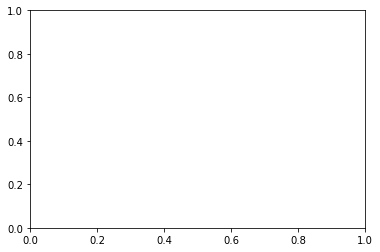

In [99]:
plt.plot(np.log(h[1:n]), np.log(e[:n-1]))

In [ ]:
f = np.polyfit(np.log(h[1:n]), np.log(e[:n-1]),1)
p = np.poly1d(f)
print(p)